# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [1]:
import os
from pathlib import Path
import random
import numpy as np

import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

import keras
from keras.utils import Sequence
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from weighted_loss_unet import make_weighted_loss_unet, my_loss

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageStat
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import json
import pandas as pd

import utils
from weighted_loss_unet import make_weighted_loss_unet, my_loss
import config
c = config.Config()

## Investigating data

In [2]:
from dataset import Swebcg
df = Swebcg().get_dataframe()
df['class'].value_counts()

tumor           658
immune cells    593
stroma          421
rbc              30
necrosis          6
Name: class, dtype: int64

In [3]:
# Dropping necrosis and rbc and stroma
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']
df = df[df['class'] != 'stroma']

In [4]:
def normalize_vertices(vertices):
    (x_min,y_min), (_, _) = utils.bounding_box(vertices)
    return [(x - x_min, y - y_min) for x, y in vertices]

def _bbox_to_slice(bbox):
    return (slice(int(bbox[0][1]), int(bbox[1][1]), None), 
            slice(int(bbox[0][0]), int(bbox[1][0]), None))

def generate_mask(vertices):
    img = Image.new("L", (3000, 3000), 0)
    ImageDraw.Draw(img).polygon(vertices, outline=1, fill=1)
    (left, upper), (right, lower) = utils.bounding_box(vertices)
    img = img.crop((left, upper, right+1, lower+1))
    return np.asarray(img)

df['vertices normalized'] = df['vertices'].apply(normalize_vertices)
df["obj"] = df["vertices"].apply(lambda x: _bbox_to_slice(utils.bounding_box(x)))
df['mask'] = df['vertices'].apply(generate_mask)
df['size'] = df['mask'].apply(np.sum)
df = df[df['size'] != 0]

Text(0.5, 1.0, 'Major and minor axis ratio')

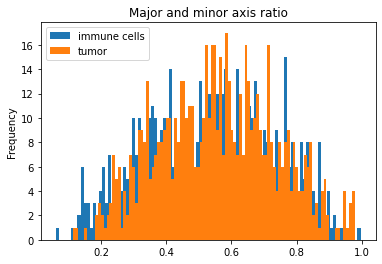

In [5]:
# Exploring major and minor axis
# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

def major_minor_axis(mask):
    if np.sum(mask) < 2:
        return 0, 0
    y, x = np.nonzero(mask)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
    v2, v1 = np.sort(evals)
    return v1, v2

df['major axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[0])
df['minor axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[1])
df['axis ratio'] = df['minor axis'] / df['major axis']
df.groupby('class')['axis ratio'].plot.hist(bins = 100)
plt.legend()
plt.title('Major and minor axis ratio')

count    1244.000000
mean      243.145498
std       191.922045
min        29.000000
25%        89.000000
50%       174.000000
75%       360.250000
max      1282.000000
Name: size, dtype: float64


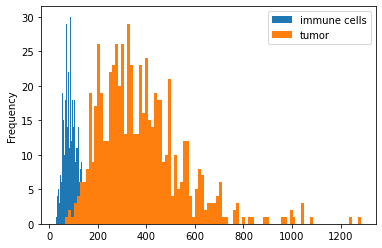

In [6]:
# Size Size varies between classes
print(df["size"].describe())
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100)
plt.legend()

In [22]:
def none_zero_brightness(im):
    b = np.nanmean(np.nanmean(np.where(im!=0,im,np.nan), 0))
    if b is None:
        return 0
    else:
        return b
        
    
def avg_brightness(ids, masks, obj):
    swebcg = Swebcg()
    avg = []
    
    images = {}
    for i in set(ids):
        images[i] = swebcg.load_image(i)
        
    for imid, mask, obj in zip(ids, masks, obj):
        img = images[imid][obj]
        mask = mask[:img.shape[0], :img.shape[1]]
        img = img[:mask.shape[0], :mask.shape[1], :]
        img = img * np.dstack((mask, mask, mask))
        avg.append(none_zero_brightness(img))
    return avg

<ipython-input-7-a7f0d2eb8971>:2: RuntimeWarning: Mean of empty slice
  b = np.nanmean(np.nanmean(np.where(im!=0,im,np.nan), 0))


Text(0.5, 1.0, 'Average brightness')

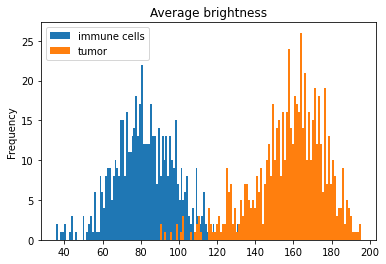

In [8]:
df["avg_brightness"] = avg_brightness(df["image_id"], df["mask"], df["obj"])
df.groupby('class')["avg_brightness"].plot.hist(bins=100)
plt.legend()
plt.title("Average brightness")

## Training basic model
We've found that the size, and brightness differ between classes. We will use these as features.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time

features = ['size', 'avg_brightness']
classes = ['tumor', 'immune cells']
df_class = pd.get_dummies(df['class'])
df_features = pd.concat([df_class, df[features]], axis=1)

np.random.seed(0) # Set random seed for test/train-split
msk = np.random.rand(len(df_features)) < 0.8
df_test = df_features[~msk]
df_train = df_features[msk]

X = df_train[features]
y = df_train[classes]

kf = KFold(n_splits=5,shuffle=True)
kf.split(X)

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
cm_list = []
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val).argmax(axis=1)
    y_val = y_val.values.argmax(axis=1)
    cm_list.append(confusion_matrix(y_val, y_pred, normalize='true'))


### Evaluation
The validation scores seem pretty promesing.

<AxesSubplot:>

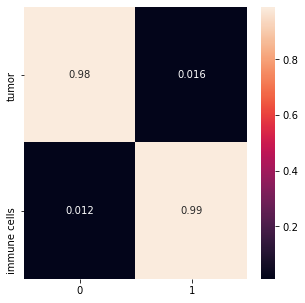

In [10]:
import seaborn as sn
df_cm = pd.DataFrame(np.mean(cm_list, axis=0), index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)

## Classifying masks predicted by U-Net

In [11]:
def iou():
    pass

name = 'unet_monuseg_400'
print("Loading existing model...", end='')
model_unet = keras.models.load_model(c.MODEL_DIR / f"{name}.h5" ,
                    custom_objects={'my_loss' : my_loss, 'iou': iou})
print("Done!")

Loading existing model...WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Done!


In [12]:
def _reshape_to_batch(patch):
    n = int(np.sqrt(c.BATCH_SIZE))
    batch = []
    for col in np.array_split(patch,n, axis=0):
        for b in np.array_split(col,n, axis=1):
            batch.append(b)
    return np.asarray(batch)
            
def _reshape_to_patch(batch):
    n = int(np.sqrt(c.BATCH_SIZE))
    patch = np.zeros((n * c.HEIGHT, n * c.WIDTH))
    i = 0
    for y in range(0, n * c.HEIGHT, c.HEIGHT):
        for x in range(0, n * c.WIDTH, c.WIDTH):
            patch[y:y+c.HEIGHT, x:x+c.WIDTH]  = batch[i,...]
            i += 1
    return patch

In [13]:
from skimage.transform import resize
from joblib import Memory

memory = Memory('./cache')

@memory.cache
def make_pred(im_id, model_name):
    model = keras.models.load_model(f'{model_dir}/{model_name}.h5',
                    custom_objects={'my_loss' : my_loss, 'iou': iou})
    img = Swebcg().load_image(im_id)
    scale = 2
    img = resize(img, (img.shape[0]*scale, img.shape[1]*scale)) * 255
    
    b_width = int(np.sqrt(c.BATCH_SIZE))
    stride = int(c.HEIGHT/2)
    pred = np.zeros(img.shape[0:2])
    norm_mat = np.ones_like(pred)
    for y in tqdm(range(0, pred.shape[1], stride)):
        for x in range(0, pred.shape[0], stride):
            img_patch = img[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH]
            batch_patch = np.zeros((b_width * c.HEIGHT, b_width * c.HEIGHT, c.CHANNELS))
            batch_patch[:img_patch.shape[0], :img_patch.shape[1]] = img_patch
            batch = _reshape_to_batch(batch_patch)
            pred_batch = model.predict(batch)[...,1]
            pred_patch = _reshape_to_patch(pred_batch)
            pred[y:y+ b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += pred_patch[:img_patch.shape[0], :img_patch.shape[1]]
            norm_mat[y:y + b_width * c.HEIGHT, x:x + b_width * c.WIDTH] += 1
    
    pred = pred / norm_mat
    return resize(pred, (int(img.shape[0]/scale), int(img.shape[1]/scale)))

In [28]:
from scipy.ndimage import find_objects
from skimage import measure
from skimage import segmentation
from skimage import morphology

# TODO
#labels = segmentation.random_walker(mask, pred[~mask])

def post_processing(prediction, p = [0.4, 5, 15]):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    prediction = morphology.remove_small_objects(prediction, min_size=p[2])
    prediction = morphology.dilation(prediction, morphology.square(3))
    return prediction

def get_objects(mask):
    all_labels = measure.label(mask, background=0)
    return find_objects(all_labels)

masks = {}
for im_id in tqdm(df["image_id"].unique(), desc="Postprocessing"):
    masks[im_id] = post_processing(make_pred(im_id, 'unet_monuseg_400'))
    

Postprocessing: 100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


In [15]:
df = df[df["image_id"].isin(masks.keys())]
df["unet_mask"] = df.apply(lambda x: masks[x.image_id][x.obj], axis=1)
df["unet_avg_brightness"] = avg_brightness(df["image_id"], df["unet_mask"], df["obj"])
df["unet_size"] = df["unet_mask"].apply(np.sum)

<ipython-input-7-a7f0d2eb8971>:2: RuntimeWarning: Mean of empty slice
  b = np.nanmean(np.nanmean(np.where(im!=0,im,np.nan), 0))


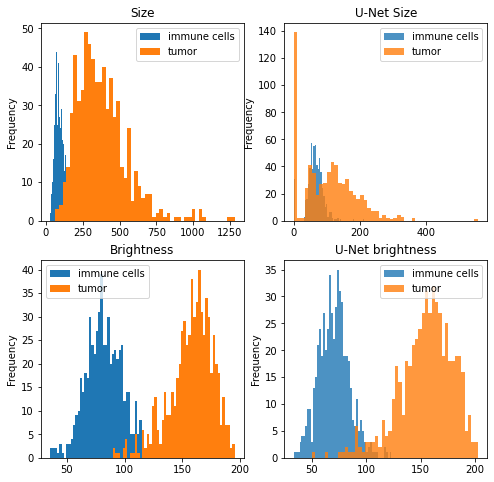

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(221)
df.groupby("class")["size"].plot.hist(bins=50)
plt.title("Size")
plt.legend()
plt.subplot(222)
df.groupby("class")["unet_size"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net Size")
plt.legend()
plt.subplot(223)
df.groupby("class")["avg_brightness"].plot.hist(bins=50)
plt.title("Brightness")
plt.legend()
plt.subplot(224)
df.groupby("class")["unet_avg_brightness"].plot.hist(bins=50, alpha=0.8)
plt.title("U-Net brightness")
plt.legend()

<Figure size 432x288 with 0 Axes>

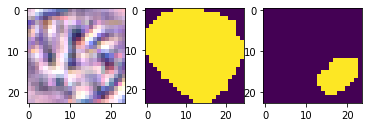

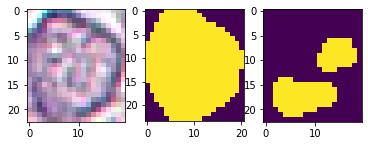

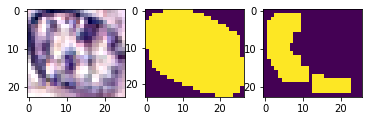

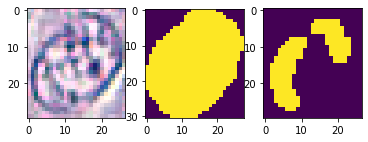

In [41]:
plt.figure()
swebcg = Swebcg()
for idx, row in df[df["class"] == "tumor"].sample(4, axis=0).iterrows():
    plt.figure()
    plt.subplot(131)
    plt.imshow(swebcg.load_image(row["image_id"])[row["obj"]])
    plt.subplot(132)
    plt.imshow(row["mask"])
    plt.subplot(133)
    plt.imshow(row["unet_mask"])

In [18]:
# Most missing cells are tumor cells
print((df[df["unet_size"] == 0]["class"].value_counts()))

tumor           132
immune cells     31
Name: class, dtype: int64


<AxesSubplot:>

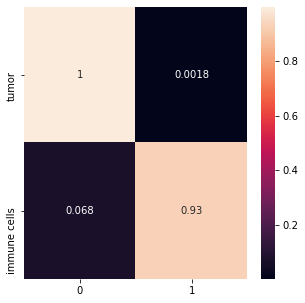

In [19]:
# Droping missing cells
df = df[df["unet_size"] > 0] 
df["pred_class"] = model.predict(df[["unet_size", "unet_avg_brightness"]].iloc[:]).argmax(axis=1)
df["pred_class"] = df["pred_class"].apply(lambda x: classes[x])

cm = confusion_matrix(df["class"], df["pred_class"], normalize='true')
df_cm_unet = pd.DataFrame(cm, index = classes)
plt.figure(figsize=(5,5))

# Of none-missing cells most are correclty classified
sn.heatmap(df_cm_unet, annot=True)

In [34]:
# Predicting all cells
d = []
for key, mask in tqdm(masks.items()):
    for obj in get_objects(mask):
        d.append({"image_id" : key,
                  "obj" : obj})
        
df_pred = pd.DataFrame(d)
df_pred["mask"] = df_pred.apply(lambda x: masks[x.image_id][x.obj], axis=1)
df_pred["avg_brightness"] = avg_brightness(df_pred["image_id"], df_pred["mask"], df_pred["obj"])
df_pred["size"] = df_pred["mask"].apply(np.sum)
df_pred["class"] = model.predict(df_pred[features].iloc[:]).argmax(axis=1)
df_pred["class_name"] = df_pred["class"].apply(lambda x: classes[x])

100%|██████████| 80/80 [00:11<00:00,  6.83it/s]
<ipython-input-22-45f02cc3014b>:2: RuntimeWarning: Mean of empty slice
  b = np.nanmean(np.nanmean(np.where(im!=0,im,np.nan), 0))


tumor           6963
immune cells    3472
Name: class_name, dtype: int64


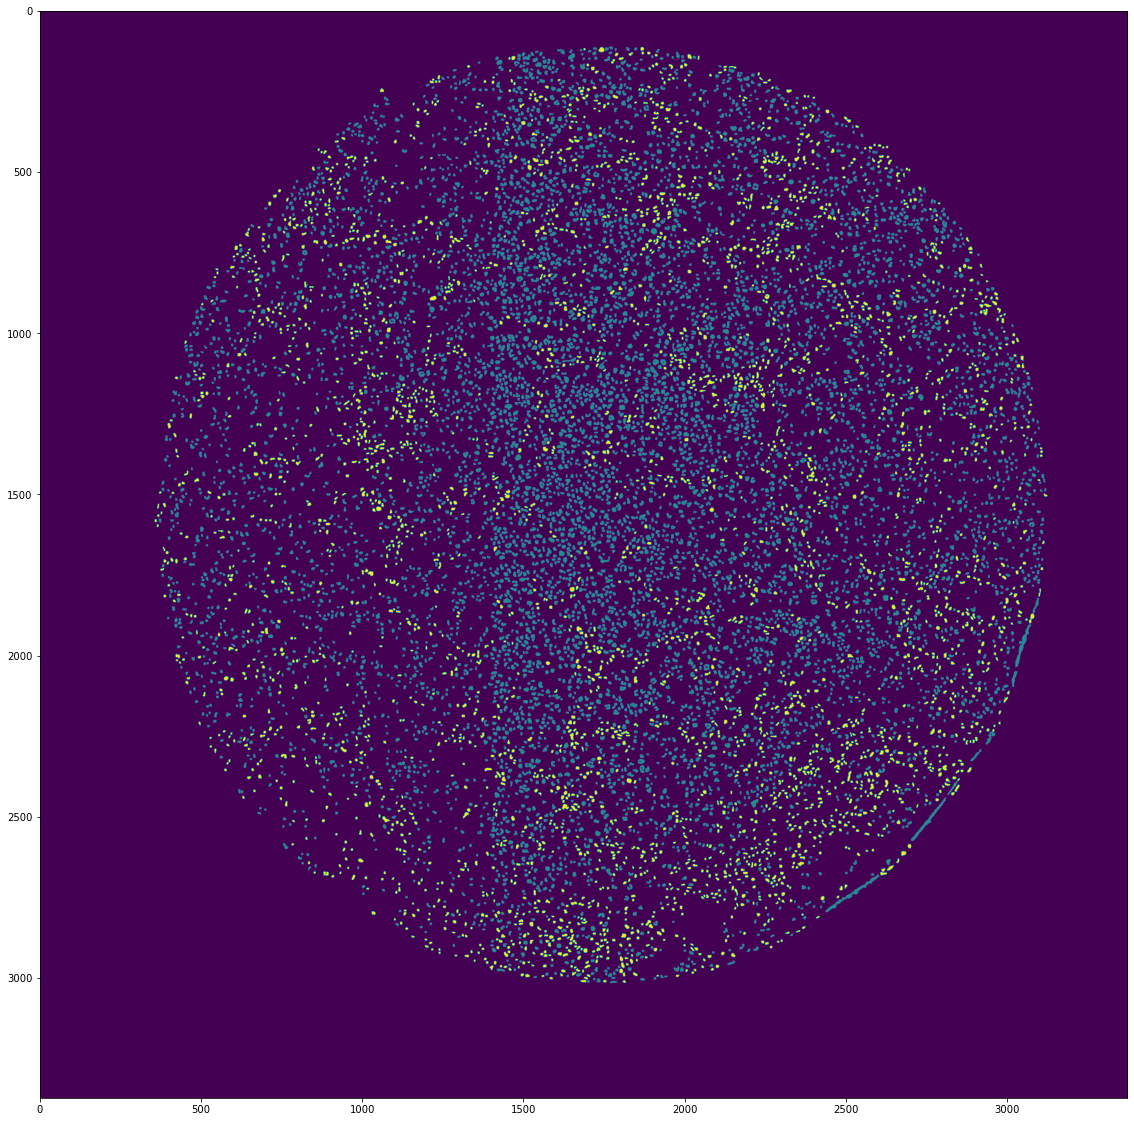

In [40]:
imid = Swebcg().ids[0]
img = Swebcg().load_image(imid)
pred = np.zeros((img.shape[0], img.shape[1]))
print(df_pred[df_pred["image_id"] == imid]["class_name"].value_counts())
for _, row in df_pred[df_pred["image_id"] == imid].iterrows():
    pred[row["obj"]] = (1 + row["class"]) * row["mask"]

plt.figure(figsize=(20,20))
plt.imshow(pred)

In [32]:
df_pred["size"]

0         63.0
1         77.0
2         62.0
3         64.0
4         83.0
          ... 
292357     NaN
292358     NaN
292359     NaN
292360     NaN
292361     NaN
Name: size, Length: 292362, dtype: float64